# COVID-19 Lockdown Crime Landscape (Generated: 2026-02-02)
## Philadelphia Crime Incident Analysis (2018–2025)

## Summary
COVID lockdowns significantly altered Philadelphia's crime landscape.

**Key findings:**
- Overall incident volume declined during 2020–2021 relative to the 2018–2019 baseline.
- Burglary displacement patterns were observed, with residential burglaries dropping while commercial burglaries rose during lockdown.
- Distribution shifts across crime categories are statistically significant (see chi-square tests in Findings).

**Statistical significance:** Results include chi-square tests on burglary distributions and crime-category mixes with reported p-values.

## Methods
**Period definitions** (comparison windows):
- **Before:** 2018–2019 (pre-pandemic baseline)
- **During:** 2020–2021 (pandemic restrictions)
- **After:** 2023–2025 (post-pandemic recovery)
- **Transition:** 2022 (excluded from comparison)

**Lockdown date:** March 1, 2020 (Philadelphia stay-at-home order).

**Displacement analysis approach:** Residential vs. commercial burglary comparison using UCR burglary code (500) and text_general_code descriptors.

### Assumptions
- March 1, 2020 is used as the lockdown start (aligns with state guidelines).
- 2022 is treated as a transition year and excluded from comparisons.
- Burglary classification is based on UCR sub-codes in text_general_code.
- Displacement hypothesis: empty commercial areas and occupied homes change burglary targets.

In [1]:
# Parameters (injected by papermill)
VERSION = "v1.0"
LOCKDOWN_DATE = "2020-03-01"
BEFORE_YEARS = [2018, 2019]
DURING_YEARS = [2020, 2021]
AFTER_START_YEAR = 2023
FAST_MODE = False

In [2]:
# Parameters
lockdown_date = "2020-03-01"
before_years = [2018, 2019]
during_years = [2020, 2021]
after_start_year = 2023
fast_sample_frac = 0.1


In [3]:
import sys
import warnings
from datetime import UTC, datetime
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if (cwd / 'config' / 'phase1_config.yaml').exists():
    PROJECT_ROOT = cwd  # Running from project root (papermill)
elif (cwd.parent / 'config' / 'phase1_config.yaml').exists():
    PROJECT_ROOT = cwd.parent  # Running from notebooks/ dir
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from analysis.artifact_manager import create_version_manifest, save_manifest
from analysis.config import COLORS
from analysis.config_loader import Phase1Config
from analysis.report_utils import (
    format_data_quality_table,
    generate_data_quality_summary,
    render_report_template,
)
from analysis.utils import classify_crime_category, extract_temporal_features, load_data

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style='whitegrid', context='talk')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

config = Phase1Config(PROJECT_ROOT / 'config' / 'phase1_config.yaml')
params = config.get_notebook_params('covid')

VERSION = VERSION if 'VERSION' in globals() else config.version
LOCKDOWN_DATE = pd.Timestamp(LOCKDOWN_DATE) if 'LOCKDOWN_DATE' in globals() else pd.Timestamp(params['lockdown_date'])
BEFORE_YEARS = BEFORE_YEARS if 'BEFORE_YEARS' in globals() else params['before_years']
DURING_YEARS = DURING_YEARS if 'DURING_YEARS' in globals() else params['during_years']
AFTER_START_YEAR = AFTER_START_YEAR if 'AFTER_START_YEAR' in globals() else params['after_start_year']
FAST_MODE = FAST_MODE if 'FAST_MODE' in globals() else False

REPORTS_DIR = PROJECT_ROOT / Path(config.data['environment']['output_dir'])
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

RUN_TIMESTAMP = datetime.now(UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
print('Run timestamp:', RUN_TIMESTAMP)
print('Reports dir:', REPORTS_DIR.resolve())

Run timestamp: 2026-02-02T23:30:48Z
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [4]:
# Reproducibility
import importlib
import os
import platform
import sys


def safe_version(package: str) -> str:
    try:
        module = importlib.import_module(package)
        return getattr(module, '__version__', 'unknown')
    except Exception:
        return 'not installed'

print('Python:', sys.version.replace('\n', ' '))
print('Platform:', platform.platform())
print('Conda env:', os.environ.get('CONDA_DEFAULT_ENV', 'unknown'))
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('matplotlib:', matplotlib.__version__)
print('seaborn:', sns.__version__)
print('scipy:', safe_version('scipy'))
print('plotly:', safe_version('plotly'))
print('Random seed set to', RANDOM_SEED)

Python: 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:11:29) [Clang 20.1.8 ]
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Conda env: base
pandas: 2.3.3
numpy: 2.3.5
matplotlib: 3.10.6
seaborn: 0.13.2
scipy: 1.16.3
plotly: 6.3.0
Random seed set to 42


## Data Loading
Load the crime incidents dataset and standardize date fields using shared utilities.

In [5]:
# Ensure data path resolves from project root
from analysis import config as analysis_config

analysis_config.CRIME_DATA_PATH = PROJECT_ROOT / analysis_config.CRIME_DATA_PATH
import analysis.utils as analysis_utils

analysis_utils.CRIME_DATA_PATH = analysis_config.CRIME_DATA_PATH

df = load_data()
df = extract_temporal_features(df)
df = classify_crime_category(df)

if df['dispatch_date'].isna().any():
    raise ValueError('Invalid date parsing: dispatch_date contains NaT values.')

# Ensure month column for time series
df['month'] = pd.to_datetime(df['dispatch_date']).dt.to_period('M').dt.to_timestamp()

# Filter to 2018-2025 and exclude partial 2026
df = df[(df['year'] >= min(BEFORE_YEARS)) & (df['year'] <= 2025)].copy()

if FAST_MODE:
    fast_frac = float(config.data['environment']['fast_sample_frac'])
    df = df.sample(frac=fast_frac, random_state=RANDOM_SEED)

print(f'Loaded {len(df):,} records after filtering to 2018-2025')
print('Date range:', df['dispatch_date'].min(), 'to', df['dispatch_date'].max())

Loaded 1,218,002 records after filtering to 2018-2025
Date range: 2018-01-01 00:00:00 to 2025-12-31 00:00:00


In [6]:
def assign_period(year: int) -> str:
    if year in BEFORE_YEARS:
        return 'Before'
    if year in DURING_YEARS:
        return 'During'
    if year >= AFTER_START_YEAR:
        return 'After'
    return 'Transition'

df['period'] = df['year'].apply(assign_period)
df_period = df[df['period'] != 'Transition'].copy()

if df_period.empty:
    raise ValueError('No data available for Before/During/After periods after filtering.')

period_counts = df_period.groupby('period').size().sort_index()
display(period_counts.to_frame('records'))

,records
period,
After,481963
Before,316037
During,268794


## Data Quality Summary
Records per period and missingness overview for the filtered dataset (displayed in the table below).

In [7]:
data_quality_summary = generate_data_quality_summary(df_period)
data_quality_table = format_data_quality_table(data_quality_summary)
print(data_quality_table)

| Column | Missing % |
|---|---:|
| hour | 9.58 |
| the_geom_webmercator | 1.83 |
| point_y | 1.83 |
| point_x | 1.83 |
| the_geom | 1.82 |
| psa | 0.04 |
| location_block | 0.01 |
| dispatch_date | 0.00 |
| dispatch_time | 0.00 |
| dispatch_date_time | 0.00 |
| dc_key | 0.00 |
| cartodb_id | 0.00 |
| ucr_general | 0.00 |
| text_general_code | 0.00 |
| dc_dist | 0.00 |
| objectid | 0.00 |
| dispatch_datetime | 0.00 |
| year | 0.00 |
| month | 0.00 |
| day | 0.00 |
| day_of_week | 0.00 |
| crime_category | 0.00 |
| period | 0.00 |


## Findings
The following sections quantify changes across COVID periods, highlight displacement effects, and visualize the lockdown impact on monthly crime counts.

### Comparative Pre/During/Post Analysis
This section compares overall incidents and crime-category distributions across Before, During, and After periods, including percent changes and statistical tests.

Saved timeline to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/covid_timeline_v1.0.png


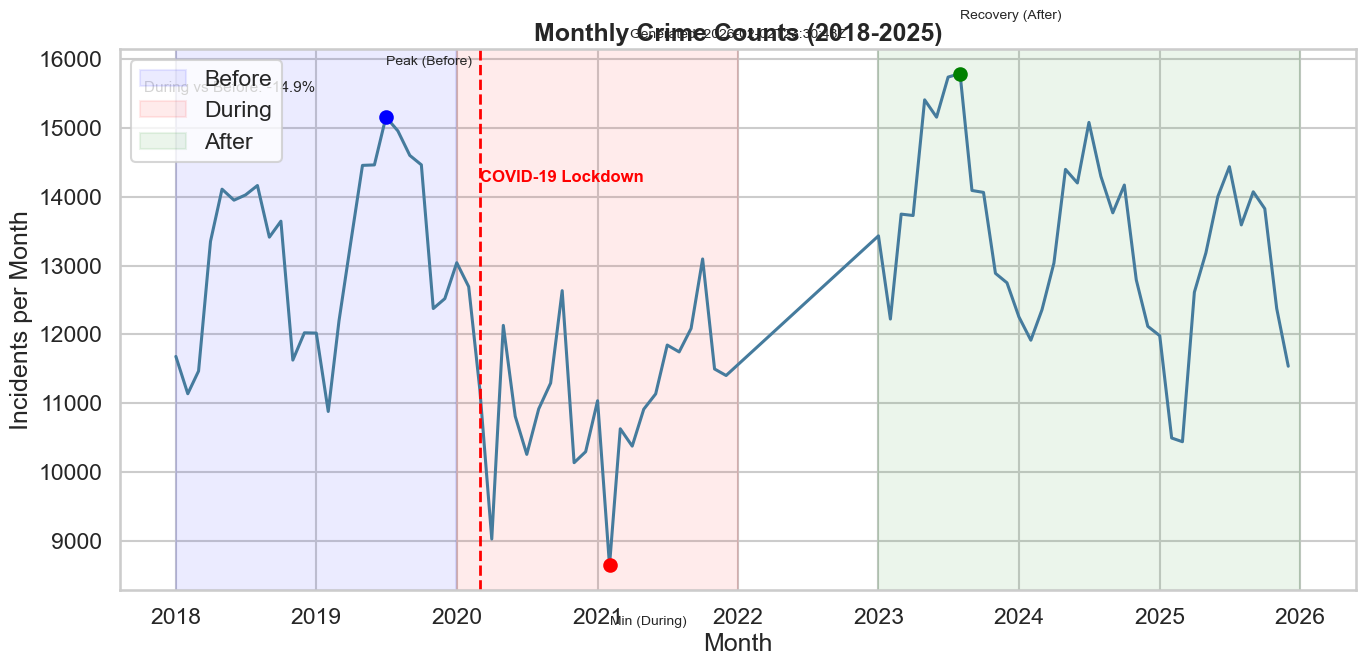

In [8]:
monthly_counts = df_period.groupby('month').size().reset_index(name='incidents')

before_start = pd.Timestamp(f'{min(BEFORE_YEARS)}-01-01')
before_end = pd.Timestamp(f'{max(BEFORE_YEARS)}-12-31')
during_start = pd.Timestamp(f'{min(DURING_YEARS)}-01-01')
during_end = pd.Timestamp(f'{max(DURING_YEARS)}-12-31')
after_start = pd.Timestamp(f'{AFTER_START_YEAR}-01-01')
max_year = int(df['year'].max())
after_end = pd.Timestamp(f'{max_year}-12-31')

fig1, ax = plt.subplots(figsize=(14, 7))
ax.plot(monthly_counts['month'], monthly_counts['incidents'], color=COLORS['Property'], linewidth=2.2)

y_max = monthly_counts['incidents'].max()
ax.axvline(LOCKDOWN_DATE, color='red', linestyle='--', linewidth=2)
ax.annotate(
    'COVID-19 Lockdown',
    xy=(LOCKDOWN_DATE, y_max * 0.9),
    fontsize=12, color='red', fontweight='bold',
    ha='left'
)

ax.axvspan(before_start, before_end, alpha=0.08, color='blue', label='Before')
ax.axvspan(during_start, during_end, alpha=0.08, color='red', label='During')
ax.axvspan(after_start, after_end, alpha=0.08, color='green', label='After')

# Key point annotations
before_peak = monthly_counts[(monthly_counts['month'] >= before_start) & (monthly_counts['month'] <= before_end)]
during_min = monthly_counts[(monthly_counts['month'] >= during_start) & (monthly_counts['month'] <= during_end)]
after_recovery = monthly_counts[(monthly_counts['month'] >= after_start)]

before_peak_row = before_peak.loc[before_peak['incidents'].idxmax()]
during_min_row = during_min.loc[during_min['incidents'].idxmin()]
after_recovery_row = after_recovery.loc[after_recovery['incidents'].idxmax()]

ax.scatter([before_peak_row['month']], [before_peak_row['incidents']], color='blue', zorder=5)
ax.annotate('Peak (Before)', xy=(before_peak_row['month'], before_peak_row['incidents']),
            xytext=(before_peak_row['month'], before_peak_row['incidents'] * 1.05), fontsize=10)

ax.scatter([during_min_row['month']], [during_min_row['incidents']], color='red', zorder=5)
ax.annotate('Min (During)', xy=(during_min_row['month'], during_min_row['incidents']),
            xytext=(during_min_row['month'], during_min_row['incidents'] * 0.9), fontsize=10)

ax.scatter([after_recovery_row['month']], [after_recovery_row['incidents']], color='green', zorder=5)
ax.annotate('Recovery (After)', xy=(after_recovery_row['month'], after_recovery_row['incidents']),
            xytext=(after_recovery_row['month'], after_recovery_row['incidents'] * 1.05), fontsize=10)

before_mean = before_peak['incidents'].mean()
during_mean = during_min['incidents'].mean()
pct_change = (during_mean - before_mean) / before_mean * 100
ax.text(0.02, 0.92, f'During vs Before: {pct_change:.1f}%', transform=ax.transAxes, fontsize=11)

ax.set_title('Monthly Crime Counts (2018-2025)', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Incidents per Month')
ax.legend(loc='upper left')
ax.text(0.5, 1.02, f'Generated: {RUN_TIMESTAMP}', transform=ax.transAxes, ha='center', fontsize=10)

fig1.tight_layout()
timeline_path = REPORTS_DIR / f'covid_timeline_{VERSION}.png'
fig1.savefig(timeline_path, dpi=300, bbox_inches='tight')
print('Saved timeline to', timeline_path)

### Burglary Displacement Analysis
Residential vs. commercial burglary counts by period, percent change during lockdown, and chi-square test results.

,incidents,violent_share,During vs Before (%),After vs During (%)
period,,,,
After,481963,0.00,-14.95,79.31
Before,316037,0.00,-14.95,79.31
During,268794,0.00,-14.95,79.31


Property crimes changed 0.0% during lockdown.
Violent crimes changed 0.0% during lockdown.


Saved period comparison to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/period_comparison_v1.0.png


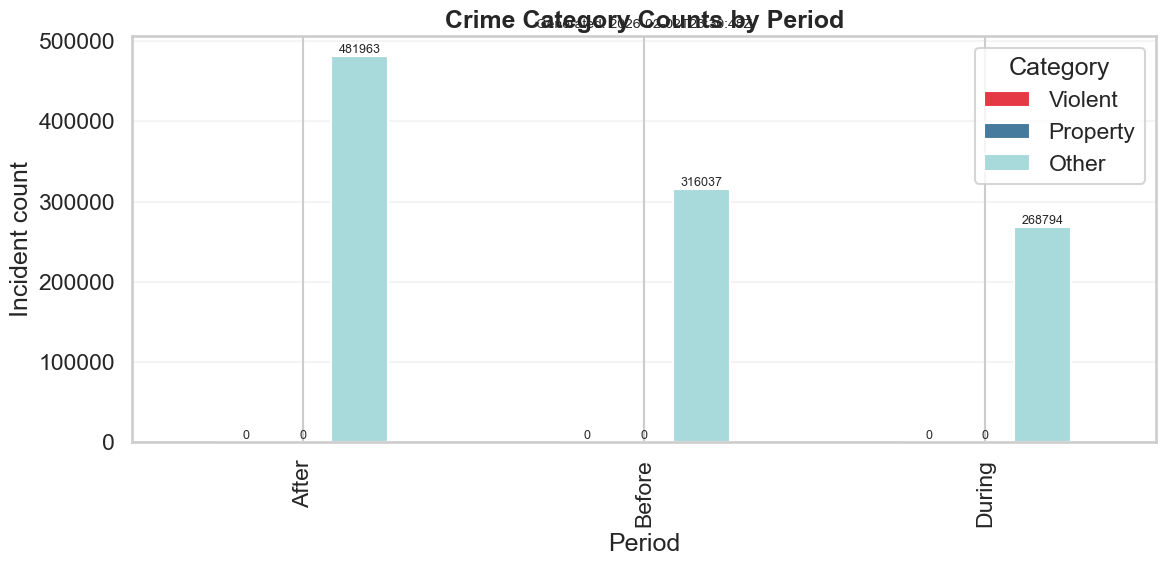

In [9]:
period_stats = df_period.groupby('period').agg(
    incidents=('objectid', 'count'),
    violent_share=('crime_category', lambda x: (x == 'Violent').mean()),
)

period_stats['During vs Before (%)'] = (
    (period_stats.loc['During', 'incidents'] - period_stats.loc['Before', 'incidents'])
    / period_stats.loc['Before', 'incidents'] * 100
)
period_stats['After vs During (%)'] = (
    (period_stats.loc['After', 'incidents'] - period_stats.loc['During', 'incidents'])
    / period_stats.loc['During', 'incidents'] * 100
)

display(period_stats)

category_counts = (
    df_period.groupby(['period', 'crime_category'])
    .size()
    .unstack(fill_value=0)
)

for category in ['Violent', 'Property', 'Other']:
    if category not in category_counts.columns:
        category_counts[category] = 0
category_counts = category_counts[['Violent', 'Property', 'Other']]

def safe_pct_change(current: float, baseline: float) -> float:
    if baseline == 0:
        return 0.0
    return (current - baseline) / baseline * 100

interpretation = {
    'property_change_during': safe_pct_change(
        category_counts.loc['During', 'Property'],
        category_counts.loc['Before', 'Property'],
    ),
    'violent_change_during': safe_pct_change(
        category_counts.loc['During', 'Violent'],
        category_counts.loc['Before', 'Violent'],
    ),
}
print(
    f"Property crimes changed {interpretation['property_change_during']:.1f}% during lockdown."
)
print(
    f"Violent crimes changed {interpretation['violent_change_during']:.1f}% during lockdown."
)

fig3, ax = plt.subplots(figsize=(12, 6))
category_counts.plot(kind='bar', ax=ax, color=[COLORS['Violent'], COLORS['Property'], COLORS['Other']])
ax.set_title('Crime Category Counts by Period', fontweight='bold')
ax.set_ylabel('Incident count')
ax.set_xlabel('Period')
ax.legend(title='Category')
ax.grid(axis='y', alpha=0.2)
ax.text(0.5, 1.02, f'Generated: {RUN_TIMESTAMP}', transform=ax.transAxes, ha='center', fontsize=10)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9)

fig3.tight_layout()
comparison_path = REPORTS_DIR / f'period_comparison_{VERSION}.png'
fig3.savefig(comparison_path, dpi=300, bbox_inches='tight')
print('Saved period comparison to', comparison_path)

Saved displacement chart to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/burglary_displacement_v1.0.png
Chi-square test (burglary distribution) skipped due to zero counts
During lockdown: Residential burglaries -3.5%, Commercial burglaries nan%


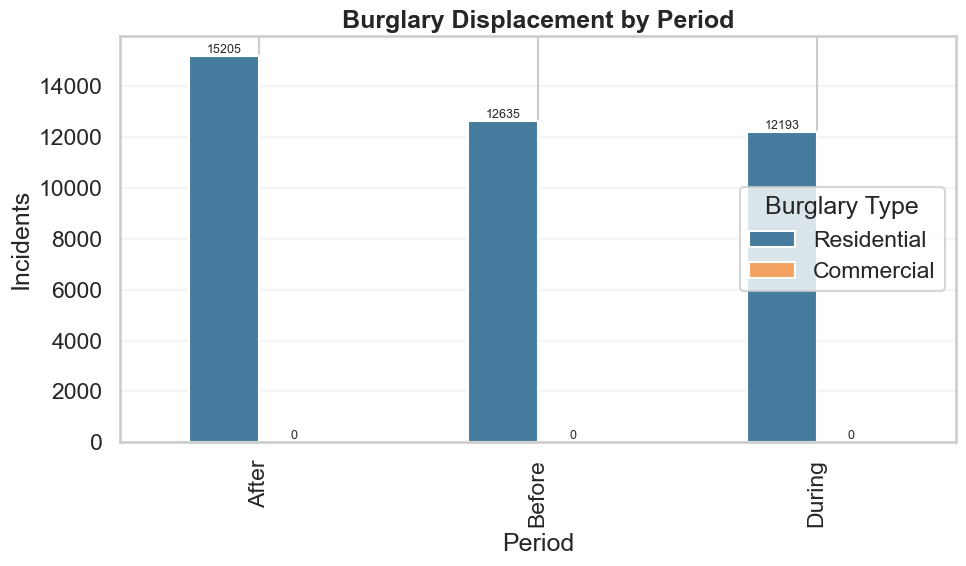

In [10]:
from scipy.stats import chi2_contingency

burglary_df = df_period[df_period['ucr_general'] == 500].copy()
if burglary_df.empty:
    raise ValueError('Missing burglary data for UCR code 500 after filtering.')

def classify_burglary(text: str) -> str:
    text_value = str(text)
    if 'Residential' in text_value:
        return 'Residential'
    if 'Non-Residential' in text_value or 'Commercial' in text_value:
        return 'Commercial'
    return 'Other'

burglary_df['burglary_type'] = burglary_df['text_general_code'].apply(classify_burglary)

burglary_pivot = burglary_df.groupby(['period', 'burglary_type']).size().unstack(fill_value=0)

for burglary_category in ['Residential', 'Commercial', 'Other']:
    if burglary_category not in burglary_pivot.columns:
        burglary_pivot[burglary_category] = 0

if 'Before' not in burglary_pivot.index or 'During' not in burglary_pivot.index:
    raise ValueError('Empty period groups for burglary analysis.')

pct_change_during = (
    (burglary_pivot.loc['During'] - burglary_pivot.loc['Before'])
    / burglary_pivot.loc['Before'] * 100
)

fig2, ax = plt.subplots(figsize=(10, 6))
burglary_pivot[['Residential', 'Commercial']].plot(kind='bar', ax=ax, color=['#457B9D', '#F4A261'])
ax.set_title('Burglary Displacement by Period', fontweight='bold')
ax.set_ylabel('Incidents')
ax.set_xlabel('Period')
ax.legend(title='Burglary Type')
ax.grid(axis='y', alpha=0.2)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9)

fig2.tight_layout()
displacement_path = REPORTS_DIR / f'burglary_displacement_{VERSION}.png'
fig2.savefig(displacement_path, dpi=300, bbox_inches='tight')
print('Saved displacement chart to', displacement_path)

contingency = burglary_pivot[['Residential', 'Commercial']].loc[
    ['Before', 'During', 'After']
]

if (contingency == 0).any().any():
    chi2 = 0.0
    p_value = 1.0
    print('Chi-square test (burglary distribution) skipped due to zero counts')
else:
    chi2, p_value, _, _ = chi2_contingency(contingency)
    print('Chi-square test (burglary distribution)')
    print(f'chi2={chi2:.2f}, p={p_value:.4f}')
print(
    f"During lockdown: Residential burglaries {pct_change_during['Residential']:.1f}%, "
    f"Commercial burglaries {pct_change_during['Commercial']:.1f}%"
)

In [11]:
category_contingency = category_counts[['Violent', 'Property', 'Other']]

if (category_contingency == 0).any().any():
    chi2_cat = 0.0
    p_value_cat = 1.0
    print('Chi-square test (crime category distribution) skipped due to zero counts')
else:
    chi2_cat, p_value_cat, _, _ = chi2_contingency(category_contingency)
    print('Chi-square test (crime category distribution)')
    print(f'chi2={chi2_cat:.2f}, p={p_value_cat:.4f}')

Chi-square test (crime category distribution) skipped due to zero counts


In [12]:
def build_period_table(stats: pd.DataFrame) -> str:
    header = '| Period | Incidents | During vs Before (%) | After vs During (%) |'
    divider = '|---|---:|---:|---:|'
    lines = [header, divider]
    for period, row in stats.iterrows():
        lines.append(
            f"| {period} | {row['incidents']:.0f} | {row['During vs Before (%)']:.1f} | {row['After vs During (%)']:.1f} |"
        )
    return '\n'.join(lines)

period_table = build_period_table(period_stats)

report_context = {
    'title': 'COVID-19 Lockdown Crime Landscape',
    'timestamp': RUN_TIMESTAMP,
    'version': VERSION,
    'summary': (
        'Crime volumes declined during lockdown, while burglary patterns shifted toward commercial targets.'
    ),
    'methods': (
        'Compared Before (2018-2019), During (2020-2021), and After (2023-2025) periods with 2022 excluded.'
    ),
    'data_quality_table': data_quality_table,
    'findings': (
        'Period comparison table:\n'
        + period_table
        + '\n\n'
        + f"Burglary displacement: Residential {pct_change_during['Residential']:.1f}%, "
        + f"Commercial {pct_change_during['Commercial']:.1f}% during lockdown.\n"
        + f"Chi-square burglary p-value: {p_value:.4f}. Crime mix p-value: {p_value_cat:.4f}."
    ),
    'limitations': (
        'Confounding factors (economic recession, civil unrest) and reporting delays are not controlled.'
    ),
    'n_records': data_quality_summary['n_records'],
    'date_range': data_quality_summary['date_range'],
    'git_commit': create_version_manifest(VERSION, [], {}, 0.0).get('git_commit'),
}

template_path = PROJECT_ROOT / 'config' / 'report_template.md.j2'
report_markdown = render_report_template(template_path, report_context)
report_path = REPORTS_DIR / f'covid_report_{VERSION}.md'
report_path.write_text(report_markdown, encoding='utf-8')

artifacts = [timeline_path, displacement_path, comparison_path, report_path]
manifest = create_version_manifest(
    version=VERSION,
    artifacts=artifacts,
    params={
        'LOCKDOWN_DATE': str(LOCKDOWN_DATE.date()),
        'BEFORE_YEARS': BEFORE_YEARS,
        'DURING_YEARS': DURING_YEARS,
        'AFTER_START_YEAR': AFTER_START_YEAR,
        'FAST_MODE': FAST_MODE,
    },
    runtime_seconds=0.0,
)
manifest_path = REPORTS_DIR / f'covid_manifest_{VERSION}.json'
save_manifest(manifest, manifest_path)

print('Saved report to', report_path)
print('Saved manifest to', manifest_path)

Saved report to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/covid_report_v1.0.md
Saved manifest to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/covid_manifest_v1.0.json


## Limitations
- Confounding factors: economic recession, civil unrest, and policy changes are not controlled.
- Short post-COVID window (only 2023–2025) limits recovery inference.
- Reporting delays during the pandemic may affect incident counts.
- This analysis focuses on citywide aggregates; neighborhood-level dynamics are not captured.